**Purpose:** The ALL and RFS proposal data is modelled with the goal of finding an optimal model with ***interpretable and explainable*** results

**Summary of Findings:**
The best models for our data are LogisticRegression and GradientBoosting. For the ALL Model, the LogisticRegression performed slightly better, while for the RFS model the GradientBoosting performed better. That said, neither model performed well and based on the results I;d say we'remissing some key elements that dictate success. Thankfully our exercise was not to build a model that can be used to predict the outcome of future proposals, but to highlight areas where they excel or have a lack of success. The output from these will still be very useful in that sense.

**Next Steps:** The model is evaluated in detail to extract meaningful business insights for the client

# **File Setup**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import io
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
X_train_all = pd.read_pickle('/content/drive/My Drive/shared_folder/X_train_all.pkl')
X_test_all = pd.read_pickle('/content/drive/My Drive/shared_folder/X_test_all.pkl')
y_train_all = pd.read_pickle('/content/drive/My Drive/shared_folder/y_train_all.pkl')
y_test_all = pd.read_pickle('/content/drive/My Drive/shared_folder/y_test_all.pkl')

X_train_rfs = pd.read_pickle('/content/drive/My Drive/shared_folder/X_train_rfs.pkl')
X_test_rfs = pd.read_pickle('/content/drive/My Drive/shared_folder/X_test_rfs.pkl')
y_train_rfs = pd.read_pickle('/content/drive/My Drive/shared_folder/y_train_rfs.pkl')
y_test_rfs = pd.read_pickle('/content/drive/My Drive/shared_folder/y_test_rfs.pkl')

In [3]:
print('ALL')
print('X_train:', X_train_all.shape)
print('y_train:', y_train_all.shape)
print('X_test:', X_test_all.shape)
print('y_test:', y_test_all.shape)
print('RFS')
print('X_train:', X_train_rfs.shape)
print('y_train:', y_train_rfs.shape)
print('X_test:', X_test_rfs.shape)
print('y_test:', y_test_rfs.shape)

ALL
X_train: (1780, 34)
y_train: (1780,)
X_test: (445, 34)
y_test: (445,)
RFS
X_train: (1123, 40)
y_train: (1123,)
X_test: (281, 40)
y_test: (281,)


In [4]:
#Removing an index column that should not be included in modelling
X_train_all = X_train_all.drop(columns=['Unnamed: 0'])
X_test_all = X_test_all.drop(columns=['Unnamed: 0'])

Our outcome (y) was balanced between the two classes during EDA, but let's just confirm the lack of inbalance before starting

In [5]:
print('All: ', y_train_all.value_counts())
print('RFS: ', y_train_rfs.value_counts())

All:  outcome
0    901
1    879
Name: count, dtype: int64
RFS:  outcome
0    603
1    520
Name: count, dtype: int64


# **ALL Model - Logistic Regression**

We're going to start with Logistic Regression using a Lasso penalty to try and get a simpler list of important features

In [6]:
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(X_train_all, y_train_all)
y_pred_logreg_all = logreg.predict(X_test_all)
y_pred_logreg_all_probs = logreg.predict_proba(X_test_all)
y_pred_logreg_all_probs = y_pred_logreg_all_probs[:,1]

AUC Score: 0.684046


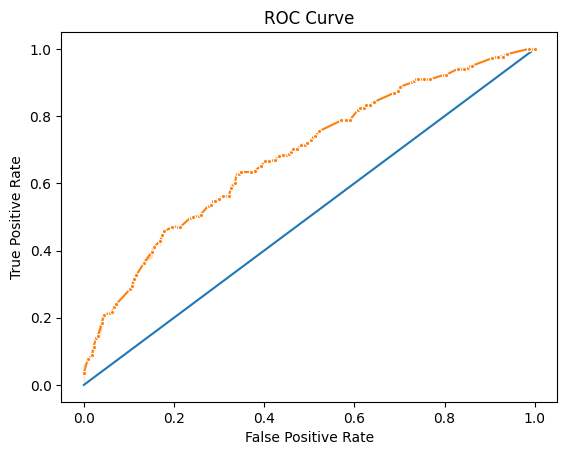

In [7]:
fpr, tpr, thresholds = roc_curve(y_test_all, y_pred_logreg_all_probs)
sns.lineplot(x=[0,1], y=[0,1], linestyle='-')
ax = sns.lineplot(x=fpr, y=tpr, marker = '.')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

auc_score = roc_auc_score(y_test_all, y_pred_logreg_all_probs)
print('AUC Score: %3f' %auc_score)

The results are ok. Better than guessing, but not great.

Based on the confusion matrix, performance isn't particularly skewed towards one outcome, so setting a higher threshold for classification as a 1 wont  significantly help our classifications

In [8]:
confusion_matrix(y_test_all, y_pred_logreg_all)

array([[146,  78],
       [ 81, 140]])

In [9]:
print('Precision: ', precision_score(y_test_all, y_pred_logreg_all))
print('Recall: ', recall_score(y_test_all, y_pred_logreg_all))

Precision:  0.6422018348623854
Recall:  0.6334841628959276


Out of curiousity, lets do a quick check on the features being used

In [16]:
coefficients = logreg.coef_[0]
feature_names = X_train_all.columns

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coeff_df)

                          Feature  Coefficient  Abs_Coefficient
13                        sow_PCA     1.724617         1.724617
4                 sow_Class 1 RFS    -1.141239         1.141239
5                 sow_Class 2 RFS    -0.957255         0.957255
16                 sow_Structural     0.838473         0.838473
11           sow_PA & Class 1 RFS    -0.554701         0.554701
12               sow_PA1, C1, PA2    -0.533160         0.533160
2                         sow_BCA     0.485881         0.485881
22                     region_TOR    -0.479366         0.479366
14                   sow_Pavement     0.475748         0.475748
32                          fee_9    -0.469583         0.469583
31                          fee_8    -0.469230         0.469230
3                     sow_Balcony    -0.378694         0.378694
27                          fee_4     0.362044         0.362044
21                   region_Other     0.345978         0.345978
9                  sow_Mechanical     0.

# **ALL Model - Classification Tree**

We're using the entropy criterion since we want informative results over balanced trees

In [10]:
dt_all = DecisionTreeClassifier(criterion = 'entropy', random_state=37)
dt_all.fit(X_train_all, y_train_all)
y_pred_dt_all = dt_all.predict(X_test_all)

The performance is again pretty weak

In [11]:
accuracy_score(y_test_all, y_pred_dt_all)

0.6134831460674157

Setting a max_depth doesn't have a significant impact on score

In [12]:
param_grid = {'max_depth': [5, 10, 15, 20]}
dt_all_grid = GridSearchCV(dt_all, param_grid, cv=5)
dt_all_grid.fit(X_train_all, y_train_all)

print(dt_all_grid.best_params_)
print(dt_all_grid.best_score_)

{'max_depth': 10}
0.6101123595505618


# **ALL Model - Random Forest**

Interestingly, our random forest has a slightly worse score than our single classification tree

In [13]:
rf_all = RandomForestClassifier(criterion = 'entropy', random_state=37)
rf_all.fit(X_train_all, y_train_all)
y_pred_rf_all = rf_all.predict(X_test_all)

print('Accuracy: ', accuracy_score(y_test_all, y_pred_rf_all))

Accuracy:  0.6089887640449438


The feature importance here is very different from what we saw in logistic regression. We'd need to dig into how the features interact more to make better sense of this. Maybe a boosted decision tree would be a better fit

<Axes: >

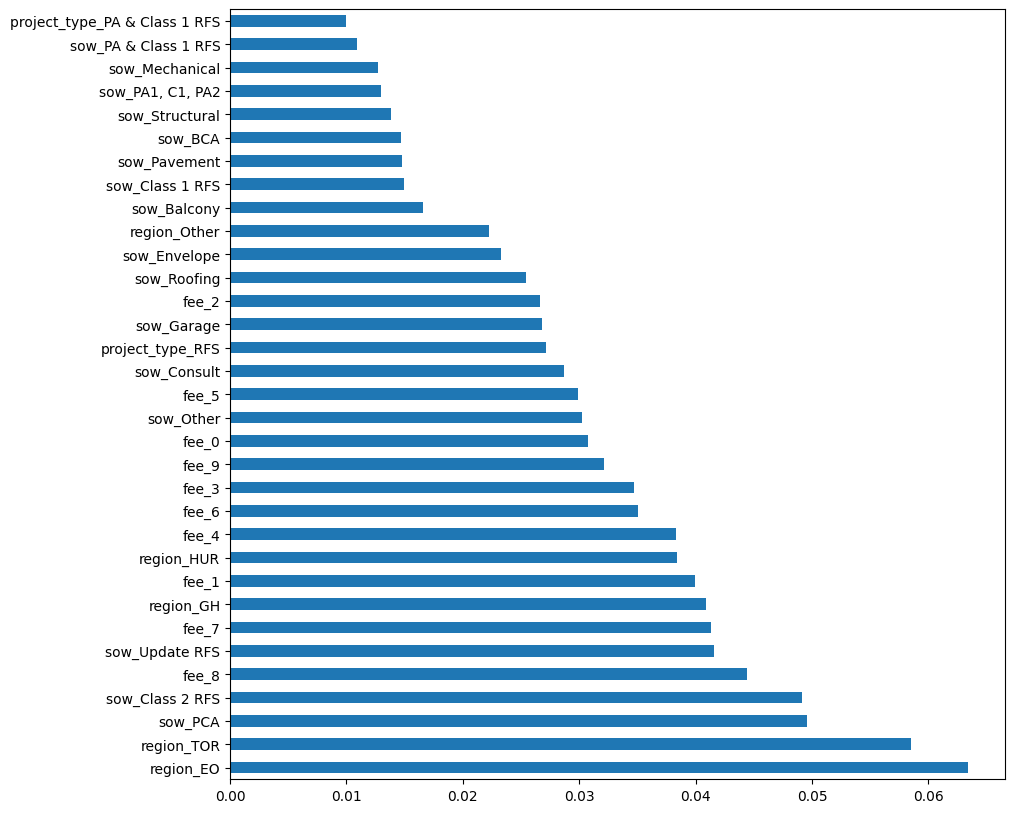

In [14]:
importances_rf = pd.Series(rf_all.feature_importances_,
                           index=X_train_all.columns).sort_values(ascending=False)

importances_rf.plot(kind='barh', figsize=(10,10))

# **ALL Model - Gradient Boosting**

This will give us one really solid decision tree which would be great from an explainability standpoint

In [18]:
def train_GB (est, max_depth, lr):
  gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate=lr, random_state=37)
  gb_all = gb.fit(X_train_all, y_train_all)
  y_pred_all = gb_all.predict(X_test_all)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test_all, y_pred_all, average='binary')
  print('Est: {} / Depth: {} / LR: {} --- Precision: {} / Recall: {} / Accuracy: {}'.format(
      est, max_depth, lr, round(precision, 3), round(recall, 3),
      round((y_pred_all==y_test_all).sum() / len(y_pred_all), 3)))

The best results are seen with:
*   Est: 50 and 150
*   Depth: 7
*   LR: 0.01 and 0.1

We'll test these further with GridSearch

In [19]:
for n_est in [50, 100, 150]:
  for max_depth in [3, 7, 10, 15]:
    for lr in [0.01, 0.1, 1]:
      train_GB(n_est, max_depth, lr)

Est: 50 / Depth: 3 / LR: 0.01 --- Precision: 0.628 / Recall: 0.557 / Accuracy: 0.616
Est: 50 / Depth: 3 / LR: 0.1 --- Precision: 0.623 / Recall: 0.584 / Accuracy: 0.618
Est: 50 / Depth: 3 / LR: 1 --- Precision: 0.624 / Recall: 0.525 / Accuracy: 0.607
Est: 50 / Depth: 7 / LR: 0.01 --- Precision: 0.647 / Recall: 0.597 / Accuracy: 0.638
Est: 50 / Depth: 7 / LR: 0.1 --- Precision: 0.64 / Recall: 0.579 / Accuracy: 0.629
Est: 50 / Depth: 7 / LR: 1 --- Precision: 0.643 / Recall: 0.529 / Accuracy: 0.62
Est: 50 / Depth: 10 / LR: 0.01 --- Precision: 0.635 / Recall: 0.52 / Accuracy: 0.613
Est: 50 / Depth: 10 / LR: 0.1 --- Precision: 0.629 / Recall: 0.561 / Accuracy: 0.618
Est: 50 / Depth: 10 / LR: 1 --- Precision: 0.62 / Recall: 0.516 / Accuracy: 0.602
Est: 50 / Depth: 15 / LR: 0.01 --- Precision: 0.638 / Recall: 0.502 / Accuracy: 0.611
Est: 50 / Depth: 15 / LR: 0.1 --- Precision: 0.639 / Recall: 0.52 / Accuracy: 0.616
Est: 50 / Depth: 15 / LR: 1 --- Precision: 0.621 / Recall: 0.511 / Accuracy: 0

Based on the below results, we'll use GB with:
*   learning_rate = 0.1
*   n_estimators = 150
*   max_depth = 7

In [30]:
gb_all = GradientBoostingClassifier()
param = {'n_estimators': [50, 150],
         'max_depth': [7],
         'learning_rate': [0.01, 0.1]}

gs_gb_all = GridSearchCV(gb_all, param, cv=5)
cv_gb_all = gs_gb_all.fit(X_train_all, y_train_all)

pd.DataFrame(cv_gb_all.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,2.210517,0.272561,0.015724,0.005033,0.10,7,150,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.612360,0.662921,0.570225,0.626404,0.657303,0.625843,0.033586,1
2,1.119186,0.315001,0.025728,0.017757,0.10,7,50,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.623596,0.632022,0.567416,0.620787,0.662921,0.621348,0.030843,2
0,0.577134,0.100850,0.008909,0.004908,0.01,7,50,"{'learning_rate': 0.01, 'max_depth': 7, 'n_est...",0.592697,0.634831,0.589888,0.640449,0.632022,0.617978,0.021975,3
1,1.501919,0.257839,0.011908,0.005022,0.01,7,150,"{'learning_rate': 0.01, 'max_depth': 7, 'n_est...",0.587079,0.629213,0.575843,0.623596,0.648876,0.612921,0.027257,4


Lets take a quick look at the resulting tree

In [22]:
gb_all_final = GradientBoostingClassifier(n_estimators=150, max_depth=7, learning_rate=0.1, random_state=37)
gb_all_final.fit(X_train_all, y_train_all)

GradientBoostingClassifier(max_depth=7, n_estimators=150, random_state=37)

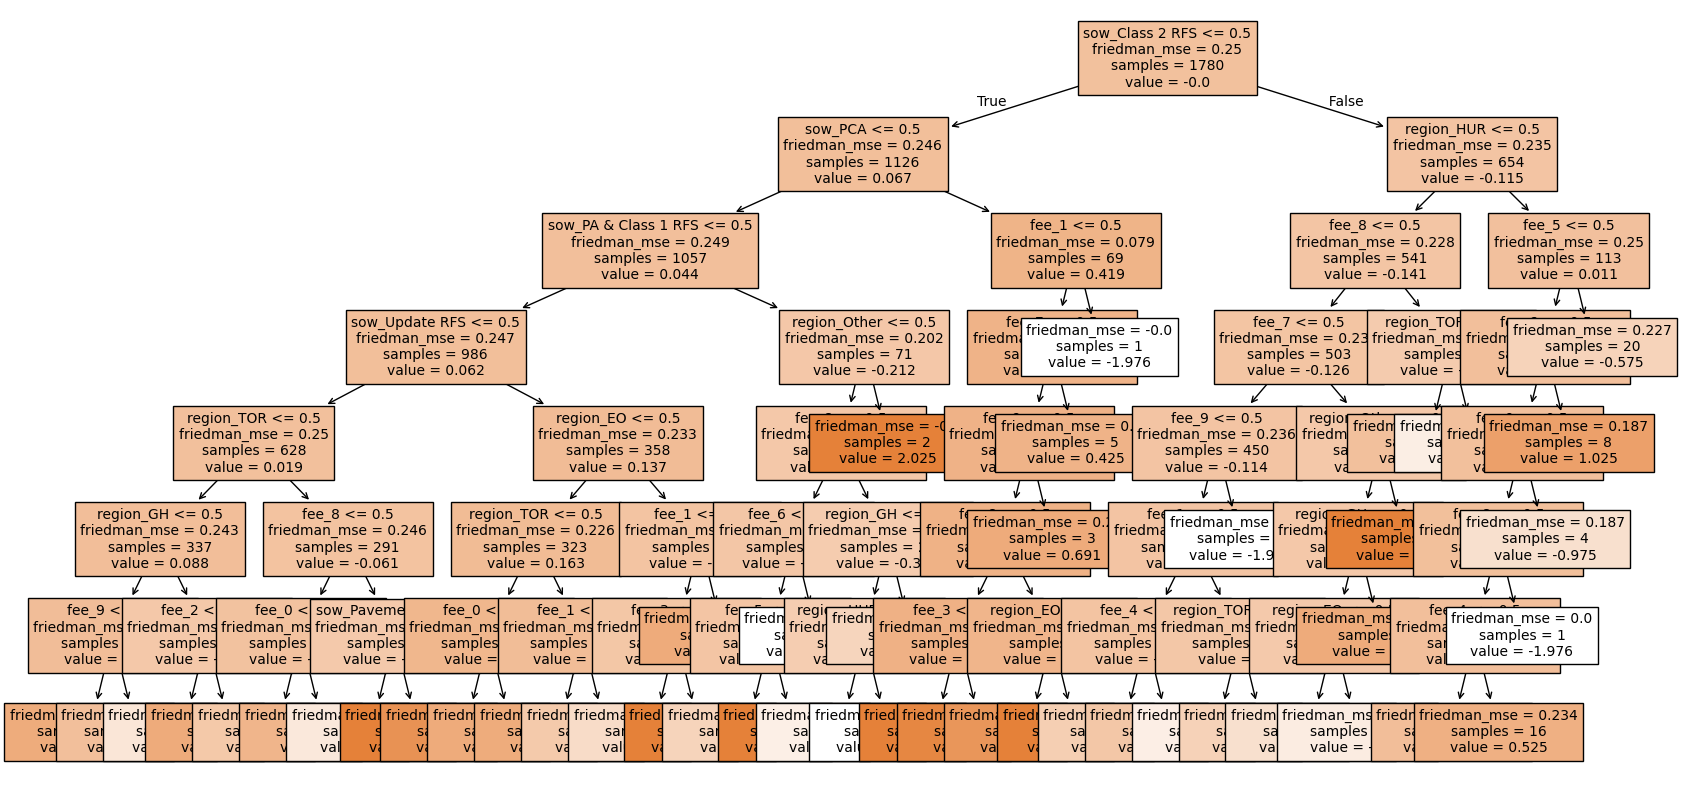

In [23]:
plt.figure(figsize=(20, 10))
plot_tree(gb_all_final.estimators_[0, 0], filled=True, feature_names=X_train_all.columns, fontsize=10)
plt.show()

# **RFS Model - Logistic Regression**

In [24]:
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(X_train_rfs, y_train_rfs)
y_pred_logreg_rfs = logreg.predict(X_test_rfs)
y_pred_logreg_rfs_probs = logreg.predict_proba(X_test_rfs)
y_pred_logreg_rfs_probs = y_pred_logreg_rfs_probs[:,1]

AUC Score: 0.692525


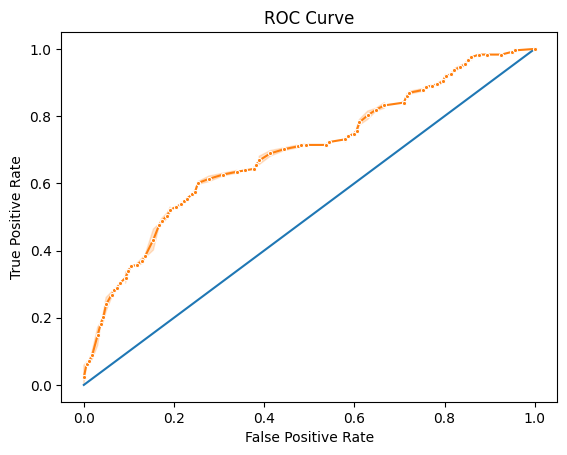

In [25]:
fpr, tpr, thresholds = roc_curve(y_test_rfs, y_pred_logreg_rfs_probs)
sns.lineplot(x=[0,1], y=[0,1], linestyle='-')
ax = sns.lineplot(x=fpr, y=tpr, marker = '.')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

auc_score = roc_auc_score(y_test_rfs, y_pred_logreg_rfs_probs)
print('AUC Score: %3f' %auc_score)

In [26]:
confusion_matrix(y_test_rfs, y_pred_logreg_rfs)

array([[110,  52],
       [ 44,  75]])

In [27]:
print('Precision: ', precision_score(y_test_rfs, y_pred_logreg_rfs))
print('Recall: ', recall_score(y_test_rfs, y_pred_logreg_rfs))

Precision:  0.5905511811023622
Recall:  0.6302521008403361


# **RFS Model - Gradient Boosting**

In [28]:
def train_GB (est, max_depth, lr):
  gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate=lr, random_state=37)
  gb_rfs = gb.fit(X_train_rfs, y_train_rfs)
  y_pred_rfs = gb_rfs.predict(X_test_rfs)
  precision, recall, fscore, support = precision_recall_fscore_support(y_test_rfs, y_pred_rfs, average='binary')
  print('Est: {} / Depth: {} / LR: {} --- Precision: {} / Recall: {} / Accuracy: {}'.format(
      est, max_depth, lr, round(precision, 3), round(recall, 3),
      round((y_pred_rfs==y_test_rfs).sum() / len(y_pred_rfs), 3)))

Best initial results are seen with:
*   n_estimators: 50, 100, 150
*   max_depth: 3, 7
*   learning_rate: 0.01, 0.1

In [29]:
for n_est in [50, 100, 150]:
  for max_depth in [3, 7, 10, 15]:
    for lr in [0.01, 0.1, 1]:
      train_GB(n_est, max_depth, lr)

Est: 50 / Depth: 3 / LR: 0.01 --- Precision: 0.602 / Recall: 0.571 / Accuracy: 0.658
Est: 50 / Depth: 3 / LR: 0.1 --- Precision: 0.567 / Recall: 0.672 / Accuracy: 0.644
Est: 50 / Depth: 3 / LR: 1 --- Precision: 0.566 / Recall: 0.613 / Accuracy: 0.637
Est: 50 / Depth: 7 / LR: 0.01 --- Precision: 0.632 / Recall: 0.563 / Accuracy: 0.676
Est: 50 / Depth: 7 / LR: 0.1 --- Precision: 0.585 / Recall: 0.639 / Accuracy: 0.655
Est: 50 / Depth: 7 / LR: 1 --- Precision: 0.565 / Recall: 0.622 / Accuracy: 0.637
Est: 50 / Depth: 10 / LR: 0.01 --- Precision: 0.577 / Recall: 0.504 / Accuracy: 0.633
Est: 50 / Depth: 10 / LR: 0.1 --- Precision: 0.566 / Recall: 0.58 / Accuracy: 0.633
Est: 50 / Depth: 10 / LR: 1 --- Precision: 0.537 / Recall: 0.613 / Accuracy: 0.612
Est: 50 / Depth: 15 / LR: 0.01 --- Precision: 0.557 / Recall: 0.454 / Accuracy: 0.616
Est: 50 / Depth: 15 / LR: 0.1 --- Precision: 0.521 / Recall: 0.521 / Accuracy: 0.594
Est: 50 / Depth: 15 / LR: 1 --- Precision: 0.555 / Recall: 0.597 / Accurac

Based on the GridSearch results, our final GradientBoosting params will be:
*   n_estimators: 50
*   max_depth: 3
*   learning_rate = 0.1



In [31]:
gb_rfs = GradientBoostingClassifier()
param = {'n_estimators': [50, 100, 150],
         'max_depth': [3, 7],
         'learning_rate': [0.01, 0.1]}

gs_gb_rfs = GridSearchCV(gb_rfs, param, cv=5)
cv_gb_rfs = gs_gb_rfs.fit(X_train_rfs, y_train_rfs)

pd.DataFrame(cv_gb_rfs.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.100125,0.004356,0.002995,0.000056,0.10,3,50,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.648889,0.680000,0.688889,0.656250,0.669643,0.668734,0.014722,1
8,0.292447,0.008875,0.003732,0.000372,0.10,3,150,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.644444,0.702222,0.702222,0.642857,0.642857,0.666921,0.028829,2
7,0.194386,0.007168,0.003204,0.000077,0.10,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.635556,0.697778,0.697778,0.647321,0.642857,0.664258,0.027625,3
2,0.446170,0.012291,0.005399,0.000184,0.01,3,150,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.648889,0.662222,0.666667,0.656250,0.665179,0.659841,0.006536,4
1,0.408749,0.106755,0.007565,0.003957,0.01,3,100,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.626667,0.662222,0.662222,0.651786,0.651786,0.650937,0.013002,5


In [32]:
gb_rfs_final = GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=37)
gb_rfs_final.fit(X_train_rfs, y_train_rfs)

GradientBoostingClassifier(n_estimators=50, random_state=37)

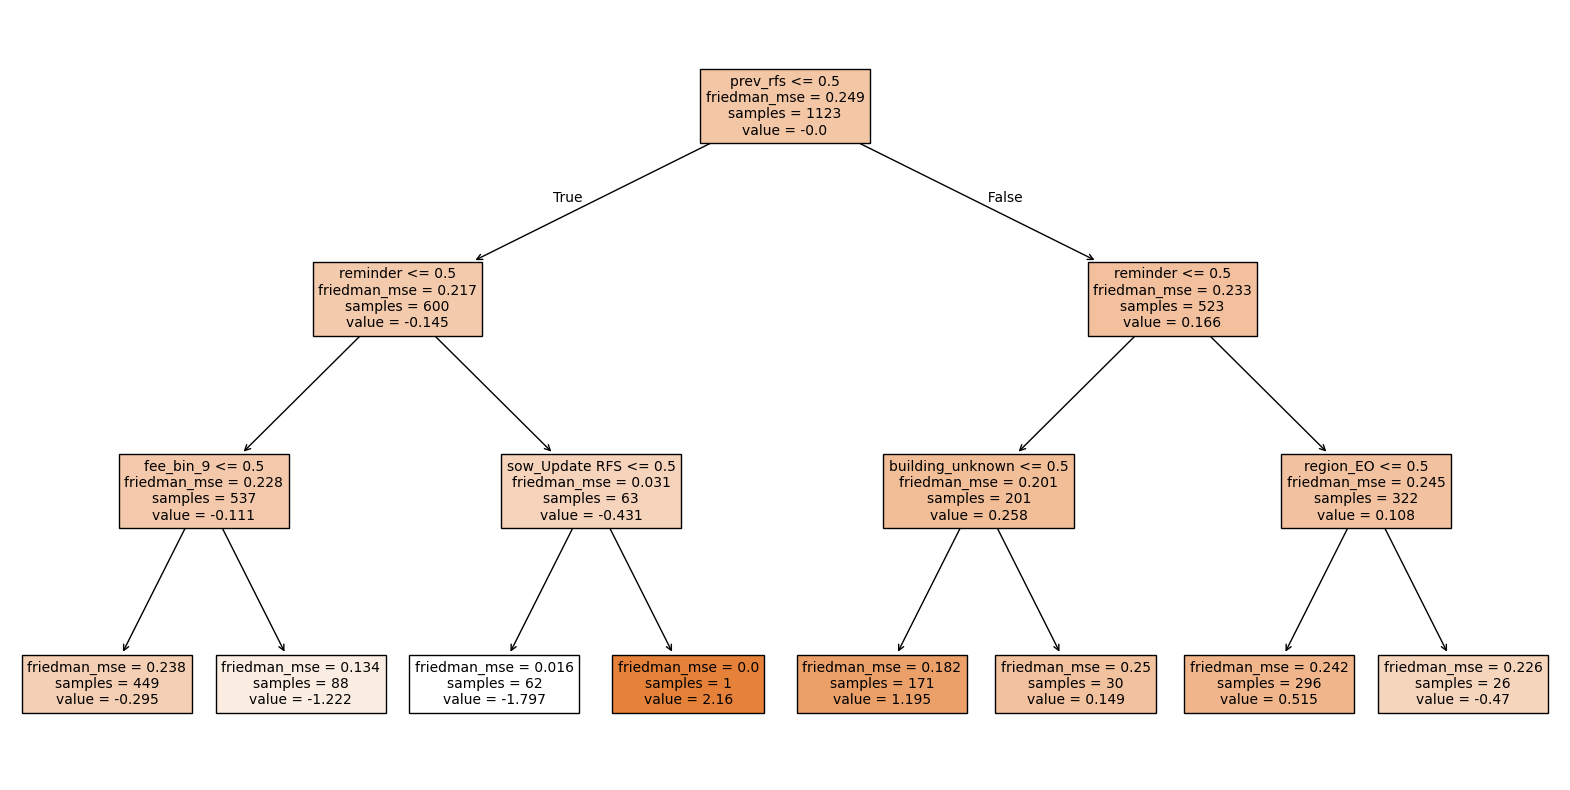

In [33]:
plt.figure(figsize=(20, 10))
plot_tree(gb_rfs_final.estimators_[0, 0], filled=True, feature_names=X_train_rfs.columns, fontsize=10)
plt.show()